## Train

### Install the necessary package

In [9]:
!pip install torch torchvision tqdm tensorboard numpy

   ### Load the package

In [1]:
import os
import math
import torch


from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

### Config for training time

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

# configration of the model
config = {
    'seed': 5201314,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 300,     # Number of epochs.
    'n_classes': 3,
    'train_root':  './dataset/train/',
    'valild_root': './dataset/val/',
    'base_channels': 3,
    'input_channels': 1,
    'input_shape': (1, 1, 150, 150),
    'depth': 4,
    'batch_size': 128,
    'learning_rate': 1e-3,
    'early_stop': 400,    # If model has not improved for this many consecutive epochs, stop training.
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}

### Define the model and Dataset

#### Define the model net

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# model

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, bias=False, padding='same')
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, bias=False, padding='same')
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut.add_module('conv', nn.Conv2d(in_channels, out_channels, 1, bias=False, padding='same'))
            self.shortcut.add_module('bn', nn.BatchNorm2d(out_channels))


    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)), inplace=True)
        y = F.relu(self.bn2(self.conv2(y)), inplace=True)
        y = y + self.shortcut(x)
        y = F.relu(y, inplace=True)
        return y


class EPNet(nn.Module):
    def __init__(self, config):
        super(EPNet, self).__init__()
        shape = config['input_shape']
        input_channel = config['input_channels']
        self.conv = nn.Conv2d(input_channel, 4, 5, padding='same')
        self.stage1 = BasicBlock(4, 8)
        self.stage2 = BasicBlock(8, 24)
        self.stage3 = BasicBlock(24, 32)
        self.stage4 = BasicBlock(32, 64)
        with torch.no_grad():
            self.feature = self._forward_test(torch.zeros(shape)).view(-1).shape[0]

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.feature, config['n_classes']),
            nn.Sigmoid()
        )

    def _forward_test(self, x):
        x = self.conv(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = F.adaptive_avg_pool2d(x, output_size=1)
        # print("average pool:", x.shape)
        return x

    def forward(self, x):
        x = self._forward_test(x)
        # x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x




#### Define dataloader

In [4]:
import numpy as np
from torch.utils.data import Dataset

class ImageDataset(Dataset):

    def __init__(self,
                 root: str,
                 # istrain: bool,
                 # data_size: int,
                 return_index: bool = False):
        # notice that:
        # sub_data_size mean sub-image's width and height.
        """ basic information """
        self.root = root
        # self.data_size = data_size
        self.return_index = return_index

        """ read all data information """
        self.data_infos = self.getDataInfo(root)
        # print(self.data_infos)


    def getDataInfo(self, root):
        data_infos = []
        folders = os.listdir(root)
        folders.sort() # sort by alphabet
        # print("[dataset] class number:", len(folders))
        eye = np.eye(len(folders), dtype=np.float32)
        for class_id, folder in enumerate(folders):
            files = os.listdir(root+folder)
            class_files = root + folder
            for file in files:
                data_path = class_files+"/"+file
                data_infos.append({"path":data_path, "label":eye[class_id]})
        return data_infos

    def __len__(self):
        return len(self.data_infos)

    def __getitem__(self, index):
        # get data information.
        image_path = self.data_infos[index]["path"]
        label = self.data_infos[index]["label"]

        img = np.load(image_path).astype(np.float32)
        
        if self.return_index:
            return index, img, label

        return img, label


In [5]:
from torch.utils.data import DataLoader

def build_loader(config):
    train_set, train_loader = None, None
    if config['train_root'] is not None:
        train_set = ImageDataset(root=config['train_root'], return_index=False)
        train_loader = DataLoader(train_set, shuffle=True, batch_size=config['batch_size'])

    val_set, val_loader = None, None
    if config['valild_root'] is not None:
        val_set = ImageDataset(root=config['valild_root'], return_index=False)
        val_loader = DataLoader(val_set, shuffle=True, batch_size=config['batch_size'])
        # only give the number of batch size data

    return train_loader, val_loader


### Define the training function

In [11]:
# Train
# model = test()
def train(model, train_loader, valid_loader, config, device):
    # ll = nn.MSELoss()
    ll = nn.CrossEntropyLoss()

    # optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.8)

    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=1e-5)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

    writer = SummaryWriter() # Writer of tensorboard.
    if not os.path.isdir('./models'):
        os.mkdir('./models')

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        model.to(device)
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device.
            pred = model(x)
            loss = ll(pred, y)
            # print("pred argmax:", torch.sum(torch.argmax(pred, dim=1) == torch.argmax(y, dim=1)))

            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.

            step += 1
            loss_record.append(loss.detach().item())

            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item(),
                                    'lr':   optimizer.state_dict()['param_groups'][0]['lr']
                                    })

        mean_train_loss = sum(loss_record)/len(loss_record)

        writer.add_scalar('Loss/train', mean_train_loss, step)
        lr_scheduler.step()


        #####################

        # Valid

        #####################
        model.eval() # Set your model to evaluation mode.


        right = []
        loss_record = []
        for x, y in valid_loader:

            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                # print(f'pred.shape = {pred.shape} y.shape = {y.shape}')
                loss = ll(pred, y)
            right.append(torch.sum(torch.argmax(pred, dim=1) == torch.argmax(y, dim=1)))

            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'acc': right[-1]/config['batch_size']})


            loss_record.append(loss.item())

        mean_valid_acc = sum(right) / (len(right) * config['batch_size'])
        mean_valid_loss = sum(loss_record)/len(loss_record)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}, Accary: {mean_valid_acc:4f}%')

        writer.add_scalar('Acc/valid', mean_valid_acc, step)
        writer.add_scalar('Loss/valid', mean_valid_loss, step)




        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else:
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return



### Load dataset and init the model

In [7]:
train_loader, valid_loader = build_loader(config)

model = EPNet(config)

### Training

In [ ]:
# TODO: I am trianing on the server 3090 24GB
train(model, train_loader, valid_loader, config, device)

### Display the training loss and acc

In [8]:
# TODO: you need load its cell to see the tensorboard
print('\x1b[31mrun tendorboard.....\033[m')
%reload_ext tensorboard
%tensorboard --logdir=./best_runs/

run tendorboard.....


## Valid with the best model

In [13]:
best_mol = EPNet(config)
best_mol.load_state_dict(torch.load('./models/test1_best.ckpt', map_location='cpu'))

<All keys matched successfully>

In [ ]:
best_mol

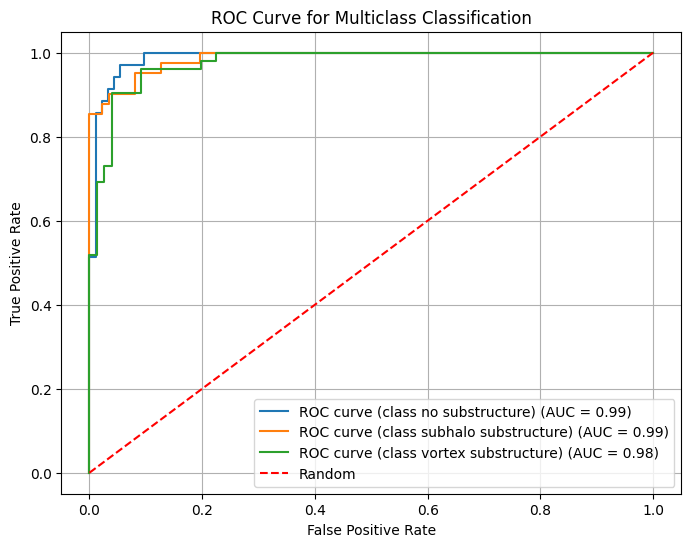

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch


# take the whole data(2500)
config['n_epochs'] = 2500
# Prepare for ROC-AUC curve
train_loader, valid_loader = build_loader(config)

images, y_label = 0, 0
for i, (X, y) in enumerate(valid_loader):
    if i == 0:
        images = X.to('cpu')
        y_label = y.to('cpu')
    

predict = best_mol(images).detach().cpu().numpy()

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_label[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, j in enumerate(['no substructure', 'subhalo substructure', 'vortex substructure']):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {}) (AUC = {:.2f})'.format(j, roc_auc[i]))

plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend()
plt.grid()
if 'img' not in os.listdir('./'):
    os.mkdir('./img')
plt.savefig('./img/test1_roc_curve.png')
plt.show()